In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = dataset.data
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.01 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, rdelta = rdelta, Beta = Beta, tracked = tracked)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 0.01, 0, 0.1262135922330097, 2000, 500, true, 50, 1, 0.001, 1.0, Dict{Any,Any}())

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, X, Y)
AnomalyDetection.evalloss(model, nX)

loss: 0.6611713023930101
reconstruction error: 0.6187401343340275
KL: 0.5754502103896175

loss: 0.032333655477210024
reconstruction error: 0.010086741784382385
KL: 2.1435392989305284

loss: 0.021422841486868852
reconstruction error: 0.007869798859792367
KL: 1.364799975406362

loss: 0.01604627743172412
reconstruction error: 0.0028599673880621464
KL: 1.2923565525453529

loss: 0.01653768189784478
reconstruction error: 0.0031944536242178995
KL: 1.2907364461189428

loss: 0.01614768124273331
reconstruction error: 0.00535066883309559
KL: 1.2976127482483528



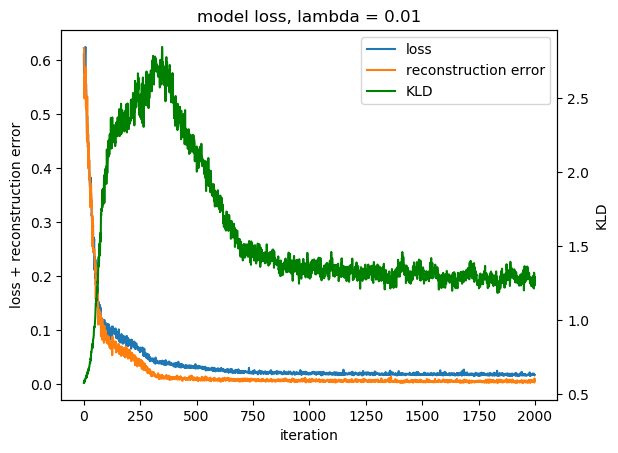

In [5]:
# plot model loss
plot(model)

In [6]:
model(nX)

Tracked 2×90 Array{Float64,2}:
 0.742156  0.717073  0.680302  0.775134  …  0.0278591  0.0213837  0.0816681
 0.767321  0.740335  0.695362  0.800842     0.991215   1.00363    0.944965 

In [7]:
nX

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float64,2}:
 -0.13197  -0.132114  -0.135152  …   0.102483   0.100138   0.107708
  1.1805    1.18405    1.19268      -1.11115   -1.08223   -1.05766 

In [9]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.962198  0.960901  0.961347  0.957738  …  0.892309  0.897805  0.903467
 0.245175  0.244654  0.244717  0.242913     0.330586  0.323914  0.325063

In [10]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.266178  0.956116  0.925084  -0.724188  …   0.666269  -1.10455  -0.259432
 1.54357   1.12243   1.06044    1.22477      -1.1348    -0.90889  -1.33799 

In [11]:
# predict labels
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1

In [12]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
recall: 0.8461538461538461
f1score: 0.9166666666666666
equal error rate: 0.07692307692307693

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
recall: 0.8461538461538461
f1score: 0.9166666666666666
equal error rate: 0.07692307692307693


In [13]:
using ScikitLearn.Utils: meshgrid

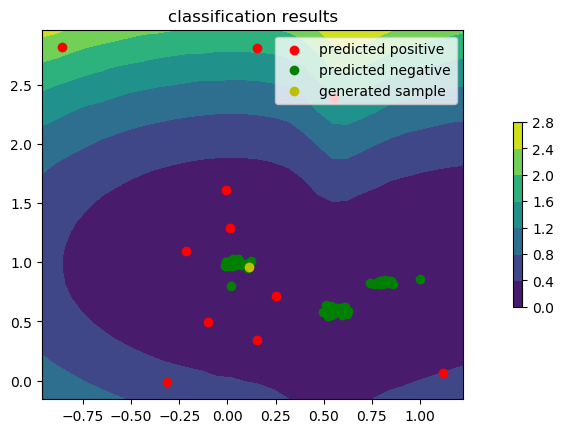

In [14]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).tracker.data
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

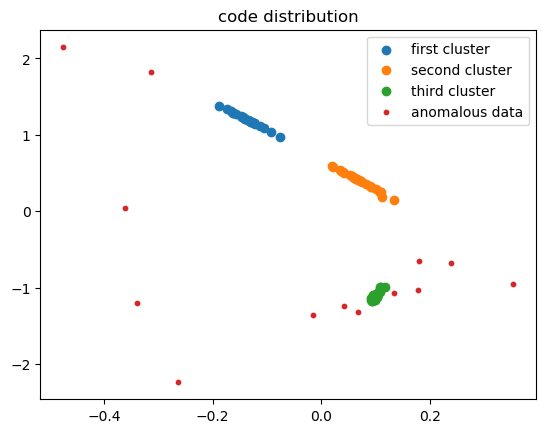

In [15]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()